## U-NET Implementation

#### Libraries

In [1]:
import os
import pylab as pl
import matplotlib.cm as cm
import itertools
import cv2
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
from numpy import ndarray
import gdal
import tensorflow as tf
import tensorlayer as tl
import math
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
import csv


#### Environment variables

In [2]:
startTime = time.time()
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rc('xtick', labelsize=10)
matplotlib.rc('ytick', labelsize=10)
rcParams['figure.figsize'] = (10,5)
tf.reset_default_graph()
#sess = tf.InteractiveSession()
gdal.AllRegister()
driver = gdal.GetDriverByName("GTiff")
wd = 'C:\\Users\\homeuser\\Documents\\MEJ\\City MSc\\09DISSERTATION\\Coding\\Tensorflow learning\\'
os.chdir(wd)
print('Current working directory is: ',os.getcwd())
np.random.seed(1337)
tf.set_random_seed(1)

Current working directory is:  C:\Users\homeuser\Documents\MEJ\City MSc\09DISSERTATION\Coding\Tensorflow learning


### DATA Processing

#### Load data

###### Training data

In [3]:
num_classes = 6
inputDirectories = ['Input','GroundTruth']
InputData = pd.DataFrame(columns=inputDirectories)
for i,each in enumerate(inputDirectories):
    path = wd + 'DryRun\\' + each
    files = []
    folders = []
    for (path, dirnames,filenames) in os.walk(path):
        print(path)
        folders.extend(os.path.join(path, name) for name in dirnames)
        files.extend(os.path.join(path, name) for name in filenames)
    InputData.iloc[:,i] = files

for row in InputData.itertuples():
    print(row[0])
    print(row[1][96:])
    print(row[2][102:])

C:\Users\homeuser\Documents\MEJ\City MSc\09DISSERTATION\Coding\Tensorflow learning\DryRun\Input
C:\Users\homeuser\Documents\MEJ\City MSc\09DISSERTATION\Coding\Tensorflow learning\DryRun\GroundTruth
0
dsm_IpCrop[2][1144-1716][0-572].tif
top_GtCrop[2][1144-1716][0-572].png
1
dsm_IpCrop[2][1144-1716][1144-1716].tif
top_GtCrop[2][1144-1716][1144-1716].png
2
dsm_IpCrop[2][1144-1716][1315-1887].tif
top_GtCrop[2][1144-1716][1315-1887].png
3
dsm_IpCrop[2][1144-1716][286-858].tif
top_GtCrop[2][1144-1716][286-858].png
4
dsm_IpCrop[2][1144-1716][572-1144].tif
top_GtCrop[2][1144-1716][572-1144].png
5
dsm_IpCrop[2][1144-1716][858-1430].tif
top_GtCrop[2][1144-1716][858-1430].png
6
dsm_IpCrop[2][1430-2002][0-572].tif
top_GtCrop[2][1430-2002][0-572].png
7
dsm_IpCrop[2][1430-2002][1144-1716].tif
top_GtCrop[2][1430-2002][1144-1716].png
8
dsm_IpCrop[2][1430-2002][1315-1887].tif
top_GtCrop[2][1430-2002][1315-1887].png
9
dsm_IpCrop[2][1430-2002][286-858].tif
top_GtCrop[2][1430-2002][286-858].png
10
dsm_IpC

###### Testing data

In [4]:
#num_classes = 6
inputTestDirectories = ['InputTest','GroundTruthTest']
InputTestData = pd.DataFrame(columns=inputDirectories)
for i,each in enumerate(inputTestDirectories):
    path = wd + 'DryRun\\' + each
    files = []
    folders = []
    for (path, dirnames,filenames) in os.walk(path):
        print(path)
        folders.extend(os.path.join(path, name) for name in dirnames)
        files.extend(os.path.join(path, name) for name in filenames)
    InputTestData.iloc[:,i] = files

for row in InputTestData.itertuples():
    print(row[0])
    print(row[1][100:])
    print(row[2][106:])

C:\Users\homeuser\Documents\MEJ\City MSc\09DISSERTATION\Coding\Tensorflow learning\DryRun\InputTest
C:\Users\homeuser\Documents\MEJ\City MSc\09DISSERTATION\Coding\Tensorflow learning\DryRun\GroundTruthTest
0
dsm_IpCrop[0][1716-2288][0-572].tif
top_GtCrop[0][1716-2288][0-572].png
1
dsm_IpCrop[0][1716-2288][1144-1716].tif
top_GtCrop[0][1716-2288][1144-1716].png
2
dsm_IpCrop[0][1716-2288][1347-1919].tif
top_GtCrop[0][1716-2288][1347-1919].png
3
dsm_IpCrop[0][1716-2288][286-858].tif
top_GtCrop[0][1716-2288][286-858].png
4
dsm_IpCrop[0][1716-2288][572-1144].tif
top_GtCrop[0][1716-2288][572-1144].png
5
dsm_IpCrop[0][1716-2288][858-1430].tif
top_GtCrop[0][1716-2288][858-1430].png


#### Binarise raster data

In [5]:
def binariseLabels(rgb, channelPosition = 3):
    if(channelPosition == 3):
        r=rgb[:,:,0]
        g=rgb[:,:,1]
        b=rgb[:,:,2]
        rows = rgb.shape[0]
        cols = rgb.shape[1]
    elif(channelPosition == 1):
        r=rgb[0,:,:]
        g=rgb[1,:,:]
        b=rgb[2,:,:]
        rows = rgb.shape[1]
        cols = rgb.shape[2]
    gt=np.zeros((rows, cols,num_classes),np.int8)
    for row in range(rows):
        for col in range(cols):
            if r[row,col] == 255 and g[row,col] == 255 and b[row,col] == 255:
                gt[row,col] = 0
            elif r[row,col] == 0 and g[row,col] == 0 and b[row,col] == 255:
                gt[row,col] = 1
            elif r[row,col] == 0 and g[row,col] == 255 and b[row,col] == 255:
                gt[row,col] = 2
            elif r[row,col] == 0 and g[row,col] == 255 and b[row,col] == 0:
                gt[row,col] = 3
            elif r[row,col] == 255 and g[row,col] == 255 and b[row,col] == 0:
                gt[row,col] = 4
            elif r[row,col] == 255 and g[row,col] == 0 and b[row,col] == 0:
                gt[row,col] = 5
    return gt[:,:,:]

#### Setting up data for feeding to Tensorflow Session.Run (i.e. Feed Input Dictionary)

###### Training dataset

In [6]:
xData = []
yLabel = []
startInd = 91
endInd = 479
xDataPath = wd + 'DryRun\\' + inputDirectories[0] + '\\'
yLabelPath = wd + 'DryRun\\' + inputDirectories[1] + '\\'
for row in InputData.itertuples():  
    xRaster = gdal.Open(xDataPath + row[1][96:]).ReadAsArray()
    xNorm = (xRaster - np.mean(xRaster))/np.std(xRaster)
    xData.append(xNorm)
    yBin = (binariseLabels(cv2.imread(yLabelPath + row[2][102:]),channelPosition = 3)).argmax(2)
    yLabel.append(yBin)
xData = np.asarray(xData)
yLabel = np.asarray(yLabel)
#yLabel = yLabel[:,91:479,91:479,:]

print('Shape of xData is: ', xData.shape)
print('Shape of yLabel is: ', yLabel.shape)

xInput = tf.convert_to_tensor(xData)
yGroundTruth = tf.convert_to_tensor(yLabel)
print('Shape of xInput tensor is: ' + str(xInput.get_shape().as_list()))
print('Shape of yGroundTruth tensor is: ' + str(yGroundTruth.get_shape().as_list()))

nSamples = xInput.get_shape().as_list()[0]
print('Total no. of data samples = ',nSamples)

Shape of xData is:  (24, 572, 572)
Shape of yLabel is:  (24, 572, 572)
Shape of xInput tensor is: [24, 572, 572]
Shape of yGroundTruth tensor is: [24, 572, 572]
Total no. of data samples =  24


###### Testing dataset

In [7]:
xDataTest = []
yLabelTest = []
startInd = 91
endInd = 479
xDataPathTest = wd + 'DryRun\\' + inputTestDirectories[0] + '\\'
yLabelPathTest = wd + 'DryRun\\' + inputTestDirectories[1] + '\\'
for row in InputTestData.itertuples():  
    xRaster = gdal.Open(xDataPathTest + row[1][100:]).ReadAsArray()
    xNorm = (xRaster - np.mean(xRaster))/np.std(xRaster)
    xDataTest.append(xNorm)
    yBin = (binariseLabels(cv2.imread(yLabelPathTest + row[2][106:]),channelPosition = 3)).argmax(2)
    yLabelTest.append(yBin)
xDataTest = np.asarray(xDataTest)
yLabelTest = np.asarray(yLabelTest)
#yLabel = yLabel[:,91:479,91:479,:]

print('Shape of xDataTest is: ', xDataTest.shape)
print('Shape of yLabelTest is: ', yLabelTest.shape)

xInputTest = tf.convert_to_tensor(xDataTest)
yGroundTruthTest = tf.convert_to_tensor(yLabelTest)
print('Shape of xInput tensor is: ' + str(xInputTest.get_shape().as_list()))
print('Shape of yGroundTruth tensor is: ' + str(yGroundTruthTest.get_shape().as_list()))

nSamplesTest = xInputTest.get_shape().as_list()[0]
print('Total no. of data samples = ',nSamplesTest)

Shape of xDataTest is:  (6, 572, 572)
Shape of yLabelTest is:  (6, 572, 572)
Shape of xInput tensor is: [6, 572, 572]
Shape of yGroundTruth tensor is: [6, 572, 572]
Total no. of data samples =  6


### CNN Definition

#### Network variables and parameters

In [8]:
# Data summary
n_input = 327184 # Input image shape: 572*572)
n_classes = 6 # Total classes (6 object types)

#Training parameters
batch_size = 2
nEpochs = 12
nBatches = int(nSamples / batch_size)
nBatchesTest = int(nSamplesTest/batch_size)
lr = 0.01
dropout = 0.5 # Dropout, probability to keep units, at the convolution layers
imageWidth = 572
imageHeight = 572
sampleSize = int(batch_size-(round((0.2*batch_size),0)))#Dropout at input layer

# tf Graph input
x = tf.placeholder(tf.float32, [None, imageWidth, imageHeight],name="Input")
y = tf.placeholder(tf.int64, [None, imageWidth, imageHeight],"Label")
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
phase = tf.placeholder(tf.bool, name='phase')

# Layer weights
weights = {
    'wd1': tf.Variable(tf.random_normal([3, 3, 1, 64])),# 3x3 conv, 1 input, 64 outputs
    'wd2': tf.Variable(tf.random_normal([3, 3, 64, 64])),# 3x3 conv, 64 input, 64 outputs
    'wd3': tf.Variable(tf.random_normal([3, 3, 64, 128])),# 3x3 conv, 64 input, 128 outputs
    'wd4': tf.Variable(tf.random_normal([3, 3, 128, 128])),# 3x3 conv, 128 inputs, 128 outputs
    'wd5': tf.Variable(tf.random_normal([3, 3, 128, 256])),# 3x3 conv, 128 inputs, 256 outputs
    'wd6': tf.Variable(tf.random_normal([3, 3, 256, 256])),# 3x3 conv, 256 inputs, 256 outputs
    'wd7': tf.Variable(tf.random_normal([3, 3, 256, 512])),# 3x3 conv, 256 inputs, 512 outputs
    'wd8': tf.Variable(tf.random_normal([3, 3, 512, 512])),# 3x3 conv, 512 inputs, 512 outputs
    'wd9': tf.Variable(tf.random_normal([3, 3, 512, 1024])),# 3x3 conv, 512 inputs, 1024 outputs
    'wd10': tf.Variable(tf.random_normal([3, 3, 1024, 1024])),# 5x5 conv, 1024 inputs, 1024 outputs

    'wu11': tf.Variable(tf.random_normal([2, 2, 512, 1024])),# 2x2 conv, 1024 inputs, 1024 outputs
    'wu12': tf.Variable(tf.random_normal([3, 3, 1024, 512])),# 3x3 conv, 1024 inputs, 512 outputs
    'wu13': tf.Variable(tf.random_normal([3, 3, 512, 512])),# 3x3 conv, 512 inputs, 512 outputs
    'wu14': tf.Variable(tf.random_normal([2, 2, 256, 512])),# 2x2 conv, 512 inputs, 256 outputs
    'wu15': tf.Variable(tf.random_normal([3, 3, 512, 256])),# 3x3 conv, 512 inputs, 256 outputs
    'wu16': tf.Variable(tf.random_normal([3, 3, 256, 256])),# 3x3 conv, 256 inputs, 256 outputs
    'wu17': tf.Variable(tf.random_normal([2, 2, 128, 256])),# 2x2 conv, 256 inputs, 128 outputs
    'wu18': tf.Variable(tf.random_normal([3, 3, 256, 128])),# 3x3 conv, 256 inputs, 128 outputs
    'wu19': tf.Variable(tf.random_normal([3, 3, 128, 128])),# 3x3 conv, 128 inputs, 128 outputs
    'wu20': tf.Variable(tf.random_normal([2, 2, 64, 128])),# 2x2 conv, 128 inputs, 64 outputs
    'wu21': tf.Variable(tf.random_normal([3, 3, 128, 64])),# 3x3 conv, 128 inputs, 64 outputs 
    'wu22': tf.Variable(tf.random_normal([3, 3, 64, 64])),# 3x3 conv, 64 inputs, 64 outputs
    
    'wu23': tf.Variable(tf.random_normal([3, 3, 64, 64])),# 3x3 conv, 64 inputs, 64 outputs 
    'wu24': tf.Variable(tf.random_normal([3, 3, 64, 64])),# 3x3 conv, 64 inputs, 64 outputs
    
    'wo1': tf.Variable(tf.random_normal([1, 1, 64, 6])),# 5x5 conv, 64 inputs, 6 outputs     
}

#Layer biases
biases = {
    'bcd1': tf.Variable(tf.random_normal([64])),
    'bcd2': tf.Variable(tf.random_normal([64])),
    'bcd3': tf.Variable(tf.random_normal([128])),
    'bcd4': tf.Variable(tf.random_normal([128])),
    'bcd5': tf.Variable(tf.random_normal([256])),
    'bcd6': tf.Variable(tf.random_normal([256])),
    'bcd7': tf.Variable(tf.random_normal([512])),
    'bcd8': tf.Variable(tf.random_normal([512])),
    'bcd9': tf.Variable(tf.random_normal([1024])),
    'bcd10': tf.Variable(tf.random_normal([1024])),
    
    'bdu11': tf.Variable(tf.random_normal([512])),
    'bcu12': tf.Variable(tf.random_normal([512])),
    'bcd13': tf.Variable(tf.random_normal([512])),
    'bdu14': tf.Variable(tf.random_normal([256])),
    'bcu15': tf.Variable(tf.random_normal([256])),
    'bcd16': tf.Variable(tf.random_normal([256])),
    'bdu17': tf.Variable(tf.random_normal([128])),
    'bcu18': tf.Variable(tf.random_normal([128])),
    'bcd19': tf.Variable(tf.random_normal([128])),
    'bdu20': tf.Variable(tf.random_normal([64])),
    'bcu21': tf.Variable(tf.random_normal([64])),
    'bcd22': tf.Variable(tf.random_normal([64])),
    
    'bcd23': tf.Variable(tf.random_normal([64])),
    'bcd24': tf.Variable(tf.random_normal([64])),    
    
    'bo1': tf.Variable(tf.random_normal([n_classes])),
}

#### Wrapper functions for convinient model creation

In [9]:
def conv2d(x, W, b, strides=1, pad='VALID'):# Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=pad)#stride=1 for width and height
    x = tf.nn.bias_add(x, b)
    return tf.nn.elu(x)

def conv2dNoReLU(x, W, b, strides=1, pad='VALID'):# Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding=pad)#stride=1 for width and height
    x = tf.nn.bias_add(x, b)
    tf.contrib.layers.batch_norm(x, decay=0.9, center=True, scale=True,updates_collections=None,
                                     is_training=phase,reuse=None,trainable=True)
                                    #renorm=True,renorm_clipping=True,renorm_decay=0.9)
    return tf.nn.sigmoid(x)

def maxpool2d(x, k=2):# MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')#k refers to the height and width of tensor which is 2 as usual

def ReLU(x):
    return tf.nn.relu(x)

def dconv2d(x, W, b, widthOp, heightOp, outChannels, strides=2):# MaxPool2D wrapper
    batchsize = tf.cast(x.get_shape().as_list()[0],dtype=tf.int32)
    x = tf.nn.conv2d_transpose(x, W, output_shape = [batchsize, widthOp, heightOp, outChannels], strides=[1, strides, strides, 1], padding='SAME')#stride=1 for width and height
    x = tf.nn.bias_add(x, b)
    return tf.nn.elu(x)

def cropGroundTruth(originalGT, prediction):# MaxPool2D wrapper
    cropStartIndex = math.floor((((int(originalGT.shape[1]) - int(prediction.shape[1]))/2)-1))
    cropEndIndex = cropStartIndex + int(prediction.shape[1])
    #yGTruth = originalGT[cropStartIndex:cropEndIndex,cropStartIndex:cropEndIndex,:]
    yGTruth = tf.slice(y,[0,cropStartIndex,cropStartIndex],[-1,388,388])
    #yGTruth = originalGT[:,cropStartIndex:cropEndIndex,cropStartIndex:cropEndIndex,:]
    return yGTruth
    
def extractForLoss(tensorData):
    return tf.slice(tensorData,[0,0,0,0],[-1,0,0,-1])

def merge(conv, dconv, axis=3):# MaxPool2D wrapper
    croppedConv = copyNcrop(conv,dconv)
    return tf.concat([croppedConv, dconv], axis)#k refers to the axis

def copyNcrop(conv,dconv):
    cropNoOfElements = dconv.get_shape().as_list()[1]
    cropIndex = (int((conv.get_shape().as_list()[1] - cropNoOfElements)/2)) - 1
    cropped = tf.slice(conv,[0,cropIndex,cropIndex,0],[-1,cropNoOfElements,cropNoOfElements,-1])
    return cropped

def log2(x):
    numerator = tf.log(x)
    denominator = tf.log(tf.constant(2, dtype=numerator.dtype))
    return numerator/denominator

def conv_net(xIn, weights, biases, dropout,batchsize):# Create model
    
    x = tf.reshape(xIn, shape=[batchsize, 572, 572, 1])# Reshape input picture

    conv1 = conv2d(x, weights['wd1'], biases['bcd1'])# Downsampling 1
    conv2 = conv2d(conv1, weights['wd2'], biases['bcd2'])
    convA = maxpool2d(conv2, k=2)
    #convA = tf.nn.dropout(convA, dropout)# Apply Dropout
    
    conv3 = conv2d(convA, weights['wd3'], biases['bcd3'])# Downsampling 2
    conv4 = conv2d(conv3, weights['wd4'], biases['bcd4'])
    convB = maxpool2d(conv4, k=2)
    #convB = tf.nn.dropout(convB, dropout)# Apply Dropout

    conv5 = conv2d(convB, weights['wd5'], biases['bcd5'])# Downsampling 3
    conv6 = conv2d(conv5, weights['wd6'], biases['bcd6'])
    convC = maxpool2d(conv6, k=2)
    #convC = tf.nn.dropout(convC, dropout)# Apply Dropout

    conv7 = conv2d(convC, weights['wd7'], biases['bcd7'])# Downsampling 4
    conv8 = conv2d(conv7, weights['wd8'], biases['bcd8'])
    convD = maxpool2d(conv8, k=2)
    convD = tf.nn.dropout(convD, dropout)# Apply Dropout

    conv9 = conv2d(convD, weights['wd9'], biases['bcd9'])
    conv10 = conv2d(conv9, weights['wd10'], biases['bcd10'])
    conv10 = tf.nn.dropout(conv10, dropout)# Apply Dropout
    dconv1 = dconv2d(conv10, weights['wu11'], biases['bdu11'], conv10.get_shape().as_list()[1]*2, 
                     conv10.get_shape().as_list()[2]*2, int(conv10.get_shape().as_list()[3]/2), 2)# Upsampling 1
    combiE = merge(conv8, dconv1, 3)
    combiE = tf.nn.dropout(combiE, dropout)# Apply Dropout

    conv11 = conv2d(combiE, weights['wu12'], biases['bcu12'])
    conv12 = conv2d(conv11, weights['wu13'], biases['bcd13'])
    dconv2 = dconv2d(conv12, weights['wu14'], biases['bdu14'], conv12.get_shape().as_list()[1]*2, 
                     conv12.get_shape().as_list()[2]*2, int(conv12.get_shape().as_list()[3]/2), 2)# Upsampling 2
    combiF = merge(conv6, dconv2, 3)
    #combiF = tf.nn.dropout(combiF, dropout)# Apply Dropout
    
    conv13 = conv2d(combiF, weights['wu15'], biases['bcu15'])
    conv14 = conv2d(conv13, weights['wu16'], biases['bcd16'])
    dconv3 = dconv2d(conv14, weights['wu17'], biases['bdu17'], conv14.get_shape().as_list()[1]*2,  
                         conv14.get_shape().as_list()[2]*2, int(conv14.get_shape().as_list()[3]/2), 2)# Upsampling 3
    combiG = merge(conv4, dconv3, 3)
    combiG = tf.nn.dropout(combiG, dropout)# Apply Dropout
    
    conv15 = conv2d(combiG, weights['wu18'], biases['bcu18'])# Downsampling 6
    conv15 = tf.nn.dropout(conv15, dropout)# Apply Dropout
    conv16 = conv2d(conv15, weights['wu19'], biases['bcd19'])
    dconv4 = dconv2d(conv16, weights['wu20'], biases['bdu20'], conv16.get_shape().as_list()[1]*2,  
                         conv16.get_shape().as_list()[2]*2, int(conv16.get_shape().as_list()[3]/2), 2)# Upsampling 4
    combiH = merge(conv2, dconv4, 3)
    #combiH = tf.nn.dropout(combiH, dropout)# Apply Dropout
    
    conv17 = conv2d(combiH, weights['wu21'], biases['bcu21'])# Downsampling 6
    conv18 = conv2d(conv17, weights['wu22'], biases['bcd22'])
    #conv18 = tf.nn.dropout(conv18, dropout)# Apply Dropout
    
    conv19 = conv2d(x=conv18, W=weights['wu23'], b=biases['bcd23'], strides=1, pad='SAME')# Downsampling 7
    conv20 = conv2d(x=conv19, W=weights['wu23'], b=biases['bcd23'], strides=1, pad='SAME')
    #conv20 = tf.nn.dropout(conv20, dropout)# Apply Dropout
    
    out = conv2dNoReLU(conv20, weights['wo1'], biases['bo1'])
    return out

### CNN Training Definition

#### CNN Prediction

In [10]:
pred = conv_net(x, weights, biases, keep_prob, sampleSize)# Construct model
print('\nShape after prediction is: ', pred.get_shape().as_list())
#maxPred = tf.reduce_max(pred)
#print('Maximum prediction = ', maxPred)
#predActual = pred/maxPred
#predActual = tf.clip_by_value(pred,1e-10,1.0)
predActual = tf.argmax(pred, 3)
print('\nShape after prediction reduction is: ', predActual.get_shape().as_list())


Shape after prediction is:  [2, 388, 388, 6]

Shape after prediction reduction is:  [2, 388, 388]


#### Ground truth for comparison

In [11]:
print('Shape of ground truth before cropping is: ', y.shape)
yGTruth = cropGroundTruth(y,pred)
print('Shape of ground truth after cropping is: ', yGTruth.shape)

Shape of ground truth before cropping is:  (?, 572, 572)
Shape of ground truth after cropping is:  (?, 388, 388)


#### Loss calculation

###### Cross entropy for exclusive class label

In [12]:
#cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=yGTruth)

###### Dice loss

In [13]:
cost = tl.cost.dice_coe(tf.cast(predActual,tf.float32), tf.cast(yGTruth,tf.float32), axis=[0,1,2])
print('Type of dice loss is: ',cost.dtype)
print('Shape of dice loss is: ', cost.get_shape().as_list())

Type of dice loss is:  <dtype: 'float32'>
Shape of dice loss is:  []


In [14]:
regWeights = tf.nn.l2_loss(weights['wd1']) + tf.nn.l2_loss(weights['wd2']) + tf.nn.l2_loss(weights['wd3']) + tf.nn.l2_loss(weights['wd4']) + tf.nn.l2_loss(weights['wd5']) + tf.nn.l2_loss(weights['wd6']) + tf.nn.l2_loss(weights['wd7']) + tf.nn.l2_loss(weights['wd8']) + tf.nn.l2_loss(weights['wd9'])+ tf.nn.l2_loss(weights['wd10'])+ tf.nn.l2_loss(weights['wu11']) + tf.nn.l2_loss(weights['wu12'])+ tf.nn.l2_loss(weights['wu13']) + tf.nn.l2_loss(weights['wu14']) + tf.nn.l2_loss(weights['wu15'])+ tf.nn.l2_loss(weights['wu16']) + tf.nn.l2_loss(weights['wu17']) + tf.nn.l2_loss(weights['wu18'])+ tf.nn.l2_loss(weights['wu19']) + tf.nn.l2_loss(weights['wu20']) + tf.nn.l2_loss(weights['wu21'])+ tf.nn.l2_loss(weights['wu22']) + tf.nn.l2_loss(weights['wu23']) + tf.nn.l2_loss(weights['wu24'])+ tf.nn.l2_loss(weights['wo1'])
beta = 0.01
regLoss = tf.reduce_mean(cost + beta * regWeights)
print('Total loss is: ',regLoss)
print('Shape of total loss is: ', regLoss.get_shape().as_list())
#batchLossPerEpoch = tf.reduce_mean(regLoss)
batchLossPerEpoch = regLoss
#finalLoss = tf.clip_by_value(regLoss,1e-10,1.0)
finalLoss = batchLossPerEpoch

Total loss is:  Tensor("Mean_1:0", shape=(), dtype=float32)
Shape of total loss is:  []


#### Optimisation

In [15]:
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    # Ensures that we execute the update_ops before performing the train_step
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(finalLoss)
#optimizer = tf.train.RMSPropOptimizer(lr).minimize(finalLoss)

#### Accuracy estimation

In [16]:
pred_vs_gt = tf.equal(predActual,yGTruth)# Evaluate model
print('Shape of prediction Vs ground truth comparison is ', pred_vs_gt.get_shape().as_list())
accuracy = tf.reduce_mean(tf.cast(pred_vs_gt, tf.float32),axis=[0,1,2], keep_dims = False)
print('accuracy is ', accuracy)
print('Shape of accuracy is ', accuracy.get_shape().as_list())

Shape of prediction Vs ground truth comparison is  [2, 388, 388]
accuracy is  Tensor("Mean_2:0", shape=(), dtype=float32)
Shape of accuracy is  []


#### Tensor board summaries

In [17]:
#Summary generation with Tensor board
#with tf.name_scope("summary"):
    #tf.summary.scalar('Loss',tf.cast(eLoss,tf.float32))
    #tf.summary.scalar('accuracy',accuracy)    
    #tf.summary.histogram('histogram_loss',eLoss)
    #tf.summary.histogram('histogram_accuracy',accuracy)
    #summaryTB = tf.summary.merge_all()

#### Initializing the variables

In [18]:
init = tf.global_variables_initializer()
#init = tf.contrib.layers.xavier_initializer()

### CNN Training

#### Batch details for training

In [19]:
print('No. of samples for training = ',nSamples)
print('No. of batches for training = ',nBatches)
print('No. of samples per batch for training = ',batch_size)
print('No. of epochs for training all the samples in every batch = ',nEpochs)
print('No. of samples for testing = ',nSamplesTest)
print('No. of samples per batch for testing = ',batch_size)
print('No. of batches for testing = ',nBatchesTest)

No. of samples for training =  24
No. of batches for training =  12
No. of samples per batch for training =  2
No. of epochs for training all the samples in every batch =  12
No. of samples for testing =  6
No. of samples per batch for testing =  2
No. of batches for testing =  3


#### Batched training of data

Dataset index range ==> Start: 0 End: 2
Optimisation ==> Epoch: 0 BatchNumber: 0 Data indices in current batch: [1, 0]
[Epoch loss]: 155550.0 [Epoch accuracy]: 0.961716
-------------------------------------------------
Dataset index range ==> Start: 2 End: 4
Optimisation ==> Epoch: 0 BatchNumber: 1 Data indices in current batch: [3, 2]
[Epoch loss]: 155519.0 [Epoch accuracy]: 0.960772
-------------------------------------------------
Dataset index range ==> Start: 4 End: 6
Optimisation ==> Epoch: 0 BatchNumber: 2 Data indices in current batch: [4, 5]
[Epoch loss]: 155488.0 [Epoch accuracy]: 0.961785
-------------------------------------------------
Dataset index range ==> Start: 6 End: 8
Optimisation ==> Epoch: 0 BatchNumber: 3 Data indices in current batch: [6, 7]
[Epoch loss]: 155457.0 [Epoch accuracy]: 0.961752
-------------------------------------------------
Dataset index range ==> Start: 8 End: 10
Optimisation ==> Epoch: 0 BatchNumber: 4 Data indices in current batch: [9, 8]
[Epo

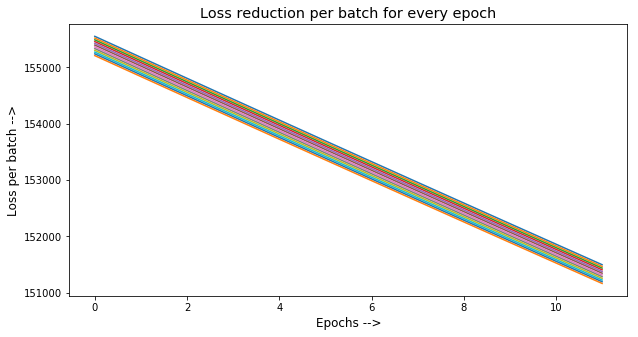

=========================************************************========================


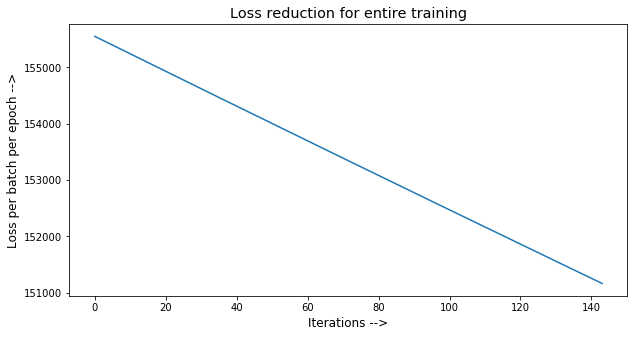

=========================************************************========================


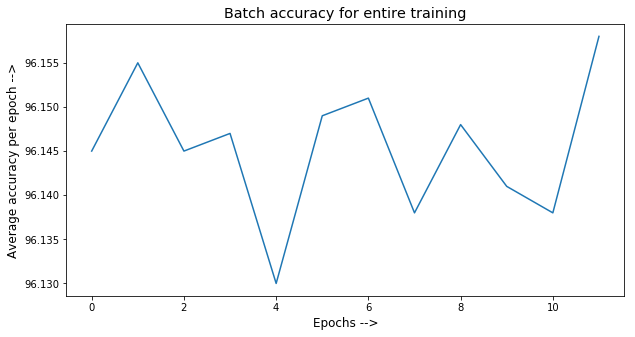

=========================************************************========================
Test accuracy is:  96.156 %


In [20]:
with tf.Session() as sess:#Launch the graph
    sess.run(init)# init all vars
    saver = tf.train.Saver() 
    writer = tf.summary.FileWriter(wd,graph=tf.get_default_graph())
    lossDF = pd.DataFrame(columns=range(nBatches))
    accuracyList = []
    for e in range(nEpochs):
        file = open("results e{}.txt".format(e),"w")
        train_loss=0
        train_accuracy=0
        for batchNumber in range (nBatches):
            startInd = batchNumber * batch_size
            endInd = (batchNumber + 1) * batch_size
            print('Dataset index range ==> Start:',startInd,'End:',endInd)
            ls = random.sample(set(np.arange(startInd,endInd)),sampleSize)
            print('Optimisation ==> Epoch:',e,'BatchNumber:',batchNumber,'Data indices in current batch:',ls)
            xSubset = np.stack([xData[i,:,:] for i in ls])
            ySubset = np.stack([yLabel[i,:] for i in ls])       
            #p,g = sess.run([predActual,yGTruth],feed_dict=
                                      #{x:xData[startInd:endInd,:],y:yLabel[startInd:endInd,:],keep_prob: dropout})
            #model,dice,opt,acc,report = sess.run([pred,dice_loss,optimizer,accuracy,summaryTB],feed_dict={x:xData,y:yLabel,keep_prob: 1.})
            model, loss, totLoss, opt, acc = sess.run([pred,finalLoss,batchLossPerEpoch,optimizer,accuracy],feed_dict=
                            {x:xSubset,y:ySubset,keep_prob: dropout,phase:1})
            file.write("e {}, batch id {} accuracy {} loss {} \n".format(e,batchNumber,acc,loss))
            print('[Epoch loss]:', totLoss,'[Epoch accuracy]:', acc)
            lossDF.loc[e,batchNumber] = totLoss
            train_accuracy = train_accuracy + acc
            print('-------------------------------------------------')
            #writer.add_summary(report,e)
        file.close()
        avgAccuracy = round((train_accuracy/nBatches)*100,3)
        accuracyList.append(avgAccuracy)
        print('Average training accuracy for Epoch [',e,'] = ',avgAccuracy,'%')
        print('=================================================')
    save_path = saver.save(sess, wd+'trainedCNN')
    print('Model saved in file: ', save_path)
    print("Optimization Finished!")
    print("Loss per batch of every epoch ==> \n",lossDF)
    print('=========================************************************========================')
        
    plt.title("Loss reduction per batch for every epoch")
    plt.xlabel('Epochs -->')
    plt.ylabel('Loss per batch -->')
    X = range(len(lossDF))
    for each in range(nBatches):
        Y = lossDF[each]
        plt.plot(X,Y)
    plt.show()
    print('=========================************************************========================')
    
    plt.title("Loss reduction for entire training")
    plt.xlabel('Iterations -->')
    plt.ylabel('Loss per batch per epoch -->')
    lossList = list(lossDF.values.flatten())
    X = range(lossDF.size)
    Y = lossList
    plt.plot(X,Y)
    plt.show()
    print('=========================************************************========================')
    
    lossCSV = 'trainingLoss_'+time.strftime("%Y%m%d%H%M%S")
    lossDF.to_csv(lossCSV+'.csv')
    
    plt.title("Batch accuracy for entire training")
    plt.xlabel('Epochs -->')
    plt.ylabel('Average accuracy per epoch -->')
    X = range(len(accuracyList))
    Y = accuracyList
    plt.plot(X,Y)
    plt.show()

    accCSV = 'trainingAccuracy_'+time.strftime("%Y%m%d%H%M%S")
    with open(accCSV+'.csv', "w") as f:
        w = csv.writer(f, lineterminator='\n')
        for val in accuracyList:
            w.writerow([val])
    print('=========================************************************========================')
    
    test_accuracy=0
    for batchNumber in range(nBatchesTest):
        startInd = batchNumber * batch_size
        endInd = (batchNumber + 1) * batch_size
        testAcc = sess.run([accuracy],feed_dict= {x:xDataTest[startInd:endInd,:,:],y:yLabelTest[startInd:endInd,:],
                                                  keep_prob: dropout,phase:0})
        test_accuracy = test_accuracy + sum(testAcc)
    overallTestAccuracy = round(((test_accuracy/nBatchesTest)*100),3)
    print("Test accuracy is: ", overallTestAccuracy,'%')    

### Execution time tracker

In [21]:
print('Total execution time is: ',round(((time.time() - startTime)/60),2),'minutes')

Total execution time is:  30.28 minutes
